# Job Finder

This notebook creates a model, to recommend job positions given a position requirements description .

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



In [5]:
import pandas as pd

# Reading the CSV file
data = pd.read_csv('/content/sample_data/data job posts.csv', encoding='utf-8')
print(data.columns)

# Selecting only IT Jobs (modify 'IT' to match your actual filter column name)
if 'IT' in data.columns:
    df = data[data['IT'] == True]  # Assuming 'IT' contains boolean values or specific job types

# Selecting required columns
cols = ['RequiredQual', 'Eligibility', 'Title', 'JobDescription', 'JobRequirment']
df = df[cols]

# Displaying the first few rows
print(df.head(5))


Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')
                                         RequiredQual Eligibility  \
4   - University degree; economical background is ...         NaN   
15  - Excellent knowledge of Windows 2000 Server, ...         NaN   
19  As a GD you are creative, innovative and have\...         NaN   
34  Participants should be mid-level professionals...         NaN   
35  - Work experience of at least two years; \r\n-...         NaN   

                            Title  \
4              Software Developer   
15          Network Administrator   
19               Graphic Designer   
34  Demographic Analysis Workshop   
35                     Programmer   

                 

In [36]:
# Display basic information about the dataset
print("Data Information:")
print(data.info())





Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3242 entries, 185 to 18995
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   jobpost                  3242 non-null   object
 1   date                     3242 non-null   object
 2   Title                    3242 non-null   object
 3   Company                  3242 non-null   object
 4   AnnouncementCode         255 non-null    object
 5   Term                     1959 non-null   object
 6   Eligibility              3242 non-null   object
 7   Audience                 89 non-null     object
 8   StartDate                2349 non-null   object
 9   Duration                 2413 non-null   object
 10  Location                 3242 non-null   object
 11  JobDescription           3242 non-null   object
 12  JobRequirment            3242 non-null   object
 13  RequiredQual             3242 non-null   object
 14  Salary                  

In [34]:
# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
jobpost                       0
date                          0
Title                         0
Company                       0
AnnouncementCode           2987
Term                       1283
Eligibility                   0
Audience                   3153
StartDate                   893
Duration                    829
Location                      0
JobDescription                0
JobRequirment                 0
RequiredQual                  0
Salary                     1365
ApplicationP                  0
OpeningDate                  30
Deadline                      1
Notes                      2779
AboutC                      857
Attach                     3033
Year                          0
Month                         0
IT                            0
JobDescription_length         0
RequiredQual_word_count       0
dtype: int64


# Modifying Job Titles
Selecting only top 21 job titles, to manage class imbalance

In [6]:
classes = df['Title'].value_counts()[:21]
keys = classes.keys().to_list()

df = df[df['Title'].isin(keys)]
df['Title'].value_counts()

Title
Software Developer           134
Web Developer                101
Java Developer                88
Graphic Designer              75
Software Engineer             69
Senior Java Developer         69
PHP Developer                 65
Senior Software Engineer      63
Programmer                    56
IT Specialist                 55
Senior QA Engineer            43
Senior Software Developer     41
Android Developer             37
.NET Developer                36
Senior .NET Developer         34
Senior PHP Developer          34
iOS Developer                 31
Software QA Engineer          29
Senior Web Developer          29
Database Developer            29
Database Administrator        28
Name: count, dtype: int64

Change job titles to base title. For exmaple, chaning Senior Java Developer to Java Developer.   

In [7]:
def chane_titles(x):
    x = x.strip()
    if x == 'Senior Java Developer':
        return 'Java Developer'
    elif x == 'Senior Software Engineer':
        return 'Software Engineer'
    elif x == 'Senior QA Engineer':
        return 'Software QA Engineer'
    elif x == 'Senior Software Developer':
        return 'Senior Web Developer'
    elif x =='Senior PHP Developer':
        return 'PHP Developer'
    elif x == 'Senior .NET Developer':
        return '.NET Developer'
    elif x == 'Senior Web Developer':
        return 'Web Developer'
    elif x == 'Database Administrator':
        return 'Database Admin/Dev'
    elif x == 'Database Developer':
        return 'Database Admin/Dev'

    else:
        return x


df['Title'] = df['Title'].apply(chane_titles)
df['Title'].value_counts()

Title
Java Developer          157
Software Developer      134
Software Engineer       132
Web Developer           130
PHP Developer            99
Graphic Designer         75
Software QA Engineer     72
.NET Developer           70
Database Admin/Dev       57
Programmer               56
IT Specialist            55
Senior Web Developer     41
Android Developer        37
iOS Developer            31
Name: count, dtype: int64

Data Visualisation


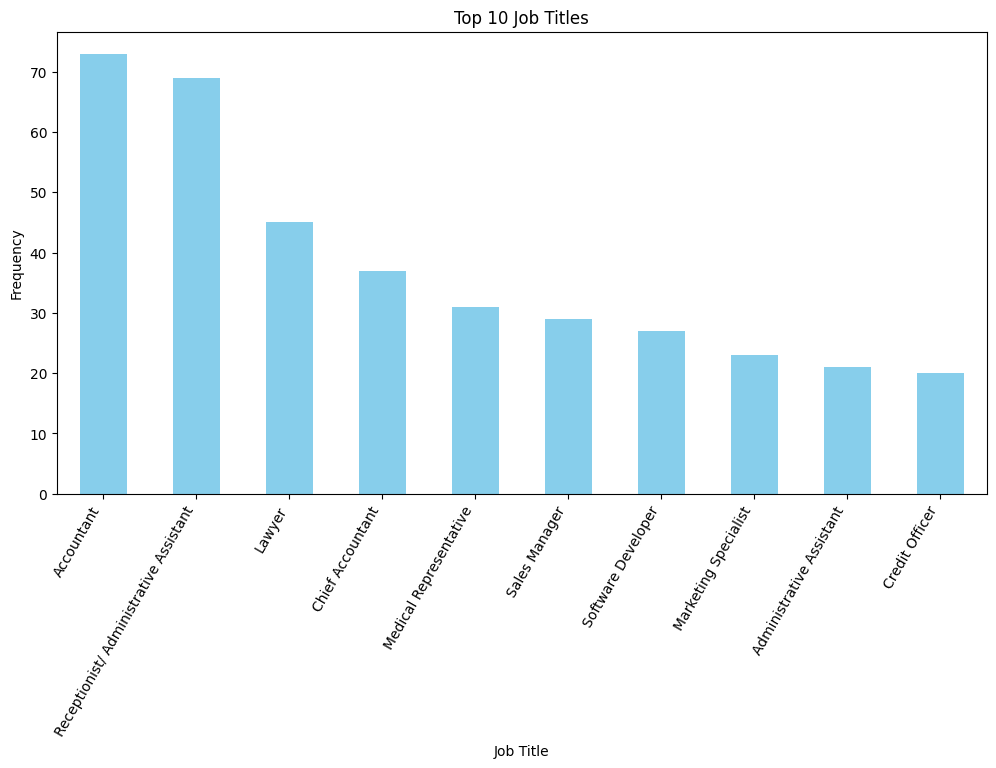

In [39]:

# Set a larger figure size for more space
plt.figure(figsize=(12, 6))

# Plot with the top 10 job titles, using value_counts
data['Title'].value_counts().head(10).plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Top 10 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')

# Adjust the rotation and font size for better readability
plt.xticks(rotation=60, ha='right', fontsize=10)

# Display the plot
plt.show()


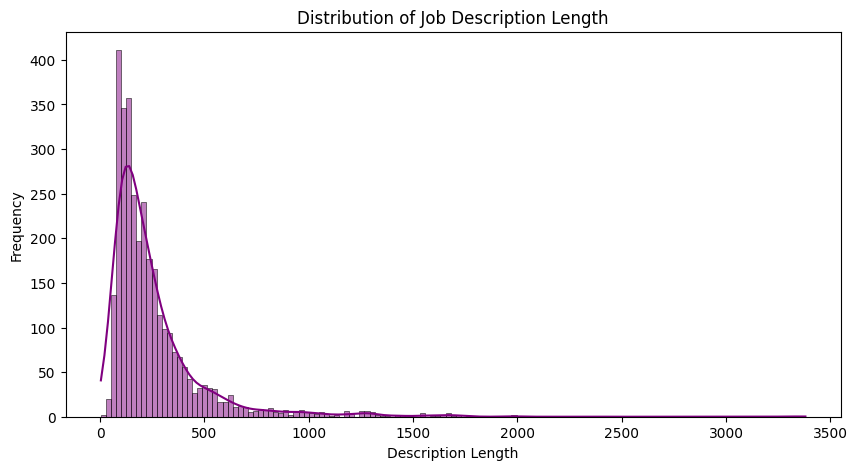

In [37]:
# Length of Job Descriptions
data['JobDescription_length'] = data['JobDescription'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 5))
sns.histplot(data['JobDescription_length'], kde=True, color='purple')
plt.title('Distribution of Job Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()


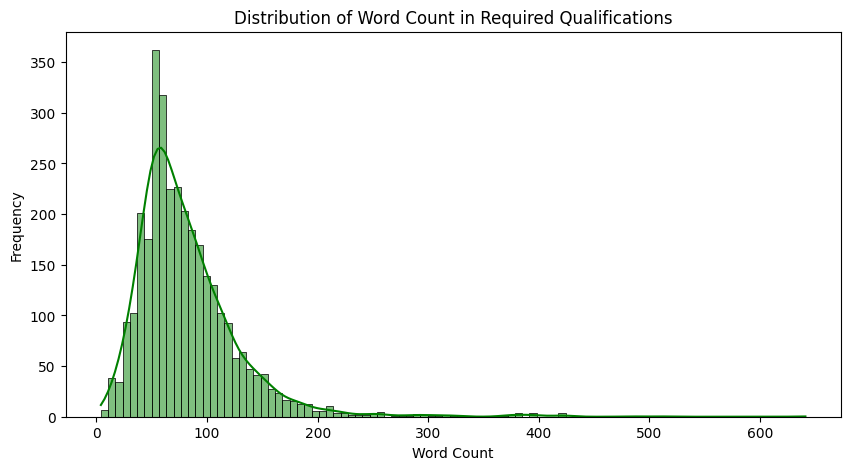

In [41]:
# Word Count in Required Qualifications
data['RequiredQual_word_count'] = data['RequiredQual'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(data['RequiredQual_word_count'], kde=True, color='green')
plt.title('Distribution of Word Count in Required Qualifications')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()




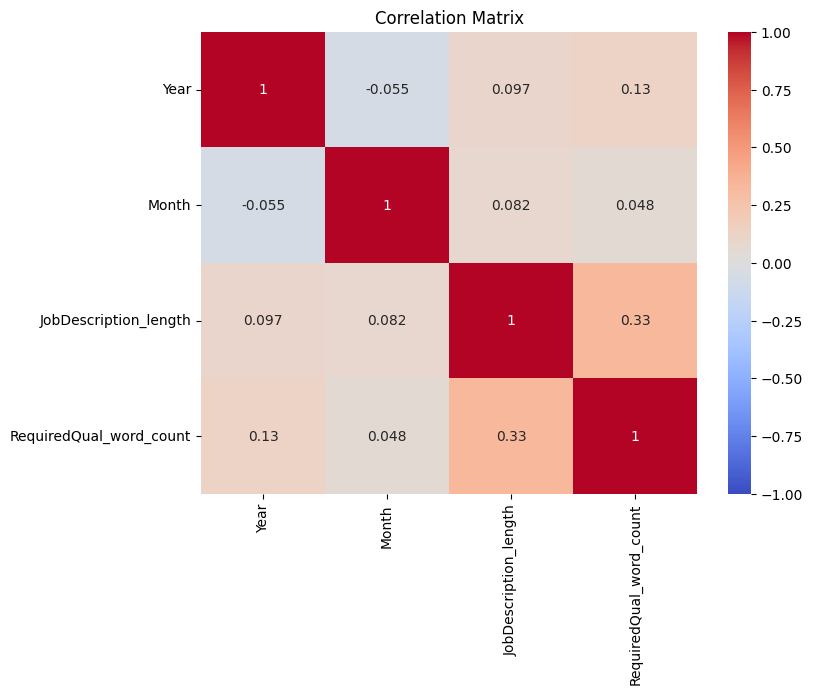


Unique values in Eligibility:
Eligibility
All qualified candidates                                                                                                                                            985
All interested candidates                                                                                                                                           580
Everyone                                                                                                                                                            209
All qualified candidates.                                                                                                                                           156
All interested and qualified candidates.                                                                                                                            141
                                                                                                                     

In [40]:
numeric_data = data.select_dtypes(include=['number'])

# Check if there are any numeric columns available for correlation
if not numeric_data.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("No numeric columns available for correlation.")

# Checking unique values in the Eligibility column
print("\nUnique values in Eligibility:")
print(data['Eligibility'].value_counts())

# Building custom tokenizer to process text

In [28]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        # lemmatize text - convert to base form
        self.wnl = WordNetLemmatizer()
        # creating stopwords list, to ignore lemmatizing stopwords
        self.stopwords = stopwords.words('english')
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.stopwords]

# removing new line characters, and certain hypen patterns
df['RequiredQual']=df['RequiredQual'].apply(lambda x: x.replace('\n', ' ').replace('\r', '').replace('- ', ''). replace(' - ', ' to '))

# Featurizing Text

In [29]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# LemmaTokenizer class with lemmatization and tokenization
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Train features and labels
y = df['Title']
X = df['RequiredQual']

# TF-IDF vectorization with stop words
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopwords.words('english'))
vectorizer.fit(X)

# Transform text to TF-IDF features
tfidf_matrix = vectorizer.transform(X)
X_tfidf = tfidf_matrix.toarray()

# Encode text labels in categories
enc = LabelEncoder()
enc.fit(y.values)
y_enc = enc.transform(y.values)

# Split data into train and test sets
X_train_words, X_test_words, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=10)

# Transform train and test text data
X_train = vectorizer.transform(X_train_words).toarray()
X_test = vectorizer.transform(X_test_words).toarray()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


# Training Naive Bayes
Looks pretty overfit

In [30]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
gnb = GaussianNB()
train_preds = gnb.fit(X_train, y_train).predict(X_train)
test_preds = gnb.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


Train acc: 0.946611909650924
Test acc: 0.6802325581395349


# Training Logistic Regression
By modifiying the maximum number of iterations, and regularization, C, the above experienced overfitting was reduced significantly


In [31]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=15,verbose=1, C=0.75)

train_preds = logistic.fit(X_train, y_train).predict(X_train)
test_preds = logistic.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


Train acc: 0.8767967145790554
Test acc: 0.7325581395348837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Creating Job Recommendations
Recommends 2 job position alternatives given a job requirement. By obtaining probability of class predictions, and picking the top N predictions, other than true label, N closest recommendations can be got

In [32]:
preds_data = {'Current Position Requirments': [], 'Current Position': [], 'Alternative 1': [], 'Alternative 2': []}
y_preds_proba = logistic.predict_proba(X_test)

counter = 0
for idx, (pred_row, true_job_position) in enumerate(zip(y_preds_proba, y_test)):
    class_preds = np.argsort(pred_row)
    # delete true class
    for i in [-1, -2]:
        if class_preds[i] == true_job_position:
            class_preds=np.delete(class_preds,i)
    # getting other 2 highest job predictions
    top_classes = class_preds[-2:]
    # obtaining class name string from int label
    class_names = enc.inverse_transform(top_classes)
    true_job_position_name = enc.inverse_transform([true_job_position])
    # saving to dict
    preds_data['Current Position Requirments'].append(X_test_words.iloc[idx])
    preds_data['Current Position'].append(true_job_position_name[0])
    preds_data['Alternative 1'].append(class_names[1])
    preds_data['Alternative 2'].append(class_names[0])


    counter +=1

In [33]:
preds_df = pd.DataFrame.from_dict(preds_data)
preds_df.to_csv('Recommendations.csv', index=False)
preds_df


Current Position Requirments    Current Position  \
0    From 1 to 5 years of experience in Android dev...   Android Developer   
1    University degree in the appropriate field of ...       PHP Developer   
2    At least 3 years of experience with PHP and Ja...       Web Developer   
3    At least 3 years of work experience as a Java ...      Java Developer   
4    Bachelor??s degree in Engineering or Informati...   Software Engineer   
..                                                 ...                 ...   
167  Artistic ability to draw, sketch and design cr...    Graphic Designer   
168  BS in Computer Science, Maths or a related dis...   Software Engineer   
169  University degree in Information Technology or...       IT Specialist   
170  University degree in Computer Science, Informa...  Software Developer   
171  At least 5 years of experience in software dev...      Java Developer   

          Alternative 1       Alternative 2  
0         iOS Developer   Software Engineer  
1         Web Developer  Software Developer  
2     Software Engineer       PHP Developer  
3     Software Engineer  Software Developer  
4    Software Developer       Web Developer  
..                  ...                 ...  
167       Web Developer  Software Developer  
168       PHP Developer  Software Developer  
169  Software Developer  Database Admin/Dev  
170   Software Engineer      Java Developer  
171   Software Engineer  Software Developer  

[172 rows x 4 columns]